# Imports 


In [193]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
import sys
from astropy.modeling.models import BlackBody
from astropy import units as u

from matplotlib import rc # for global times new roman font
from pathlib import Path
rc("font",**{"family":"serif", "serif":["Times"]})
rc("text", usetex=True)

In [194]:
runs = [1, 2, 3, 5, 6, 7]
depths = [9873.506279381681, 8934.029524345975, 8423.405023714935, 8500.143922958772, 8503.934821045383, 8390.1765008139]
errs = [51.60347163478127, 143.1915953399348, 130.688166527495, 18.52444114327136, 50.676598261274194,  129.3413199274146]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


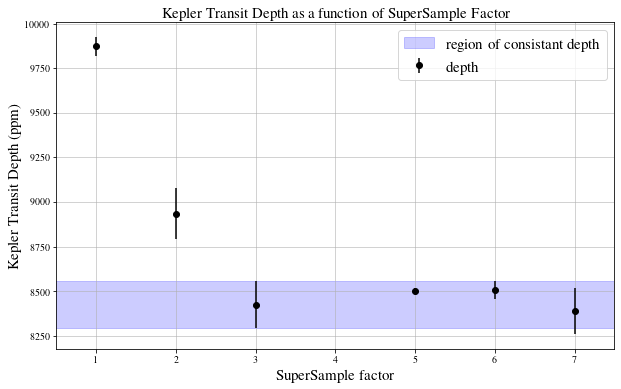

In [195]:
plt.figure(figsize=(10, 6))
plt.errorbar(runs, depths, yerr=errs, fmt="o", color="black", label="depth")

plt.fill_between(np.linspace(0, 8, 100), depths[2]-errs[2], y2=depths[2]+errs[2], color="blue", alpha=0.2, label="region of consistant depth")

plt.grid(alpha=0.7)
plt.xlim(0.5, 7.5)
plt.legend(fontsize=15)
plt.xlabel("SuperSample factor", size=15)
plt.ylabel("Kepler Transit Depth (ppm)", size=15)
plt.title("Kepler Transit Depth as a function of SuperSample Factor", size=15);

### Star Spectrum Models

In [32]:
# loads in BT-settl stellar atmosphere models 

# units of AA vs ergs/cm^2/s/AA 
spec_B_raw = np.loadtxt("lte038.0-4.5-0.0a+0.0.BT-Settl.spec.7.dat.txt")
spec_A_raw = np.loadtxt("lte058.0-4.5-0.0a+0.0.BT-Settl.spec.7.dat.txt")

### Filter transmission profiles

In [33]:
# loads in transmission profiles

# units of AA vs transmission (fraction)
kep_transmission_raw = np.loadtxt("Kepler_Kepler.K.dat")
spitz_ch1_raw = np.loadtxt("Spitzer_IRAC.I1.dat")
spitz_ch2_raw = np.loadtxt("Spitzer_IRAC.I2.dat")

### MCMC results

In [50]:
# loads in MCMC results

mcmc_output = np.load("../final_params_working.npz")
pars = mcmc_output["pars"]
errs = mcmc_output["errors"]

RpRs_kepler = [pars[4], errs[4]] 
depth_ch1 = [pars[11], errs[11]]
depth_ch2 = [pars[12], errs[12]]
depth_kepler = [pars[13], errs[13]]

print(depth_ch1)
print(depth_ch2)
print(depth_kepler)

[8062.8081528393795, 284.67063604842724]
[8247.64932897733, 244.02469776125417]
[8819.402022837698, 46.3663478735416]


### Star Radii, errors

In [35]:
# loads in star radii values, converts to correct units

to_cm = 6.95700e10 # radius of the sun in cm

RA = 1.01 * to_cm * u.cm # radius of A
sig_RA = 0.04 *to_cm * u.cm # uncertainty on radius

RB = 0.52 * to_cm * u.cm # raidus of B
sig_RB = 0.06 * to_cm * u.cm # uncertainty of radius of B

### BD radius, errors

In [36]:
# calculates Kepler radius in cm
Rp = (RpRs_kepler[0]) * RA # Assume Kepler radius is the true radius of brown dwarf, convert from RpRs -> Rp using R_A # Rp in cm

sig_Rp =(RA.value**2 * RpRs_kepler[1]** 2 + RpRs_kepler[0]**2 * sig_RA.value ** 2) ** 0.5 * u.cm
Rp_kepler = [Rp, sig_Rp] 

# Calculates $SB_{A}$, $SB_{B}$ for Kepler observation

Surface Brightness is the integral of a spectrum over wavelength 

integrate $ergs/cm^{2}/s/AA$ over $AA$ to get $ergs/cm^{2}/s$

Surface Brightness (SB) = integral of Stellar Spectrum * Transmission profile over wavelength range of filter

### Star A

In [37]:
# star A:
lam_A = spec_A_raw[:, 0] * u.AA # wavelength range of star A spectrum in AA
spectrum_A = spec_A_raw[:, 1] * u.erg/(u.cm)**2 / u.s / u.AA # spectrum of A in ergs/cm^2/s/AA : flux density

In [38]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_A_raw[:, 0] - np.min(kep_transmission_raw[:, 0]))).argmin()
i_max = (np.abs(spec_A_raw[:, 0] - np.max(kep_transmission_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_A = spec_A_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(kep_transmission_raw[:, 0], kep_transmission_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_A = spec_A[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_A = spec_A[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_A = interp_func(lam_A) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_A = transmission_A * spectrum_A

In [39]:
# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_A = sum(
    [(scaled_flux_A[i] + scaled_flux_A[i-1]) * (lam_A[i] - lam_A[i-1]) / 2 for i in range(1, len(lam_A))]
)

print("Surface brightness, star A:", SB_A)

# total_flux_A gives the total flux in ergs/cm^2/s of star A as seen by Kepler. 

Surface brightness, star A: 18880651475.642326 erg / (cm2 s)


### Star B 

In [40]:
# star A:
lam_B = spec_B_raw[:, 0] * u.AA # wavelength range of star A spectrum in AA
spectrum_B = spec_B_raw[:, 1] * u.erg/(u.cm)**2 / u.s / u.AA # spectrum of A in ergs/cm^2/s/AA : flux density

In [41]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_B_raw[:, 0] - np.min(kep_transmission_raw[:, 0]))).argmin()
i_max = (np.abs(spec_B_raw[:, 0] - np.max(kep_transmission_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_B = spec_B_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(kep_transmission_raw[:, 0], kep_transmission_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_B = spec_B[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_B = spec_B[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_B = interp_func(lam_B) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_B = transmission_B * spectrum_B

In [42]:
# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_B = sum(
    [(scaled_flux_B[i] + scaled_flux_B[i-1]) * (lam_B[i] - lam_B[i-1]) / 2 for i in range(1, len(lam_B))]
) 

print("Surface brightness, star B:", SB_B)


# total_flux_B gives the total flux in ergs/cm^2/s of star B as seen by Kepler. 

Surface brightness, star B: 1682994775.5774229 erg / (cm2 s)


# Calcualte SB for Spitzer channels 

### CH 1

In [43]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_A_raw[:, 0] - np.min(spitz_ch1_raw[:, 0]))).argmin()
i_max = (np.abs(spec_A_raw[:, 0] - np.max(spitz_ch1_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_A = spec_A_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(spitz_ch1_raw[:, 0], spitz_ch1_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_A = spec_A[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_A = spec_A[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_A = interp_func(lam_A) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_A_ch1 = transmission_A * spectrum_A

# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_A_ch1 = sum(
    [(scaled_flux_A_ch1[i] + scaled_flux_A_ch1[i-1]) * (lam_A[i] - lam_A[i-1]) / 2 for i in range(1, len(lam_A))]
) 

print("Surface brightness, star A:", SB_A_ch1)


# total_flux_B gives the total flux in ergs/cm^2/s of star B as seen by Kepler. 

Surface brightness, star A: 209111123.36627406 erg / (cm2 s)


In [44]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_B_raw[:, 0] - np.min(spitz_ch1_raw[:, 0]))).argmin()
i_max = (np.abs(spec_B_raw[:, 0] - np.max(spitz_ch1_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_B = spec_B_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(spitz_ch1_raw[:, 0], spitz_ch1_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_B = spec_B[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_B = spec_B[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_B = interp_func(lam_B) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_B_ch1 = transmission_B * spectrum_B

# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_B_ch1 = sum(
    [(scaled_flux_B_ch1[i] + scaled_flux_B_ch1[i-1]) * (lam_B[i] - lam_B[i-1]) / 2 for i in range(1, len(lam_B))]
) 

print("Surface brightness, star B:", SB_B_ch1)


# total_flux_B gives the total flux in ergs/cm^2/s of star B as seen by Kepler. 

Surface brightness, star B: 120580352.08275107 erg / (cm2 s)


### CH 2

In [45]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_A_raw[:, 0] - np.min(spitz_ch2_raw[:, 0]))).argmin()
i_max = (np.abs(spec_A_raw[:, 0] - np.max(spitz_ch2_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_A = spec_A_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(spitz_ch2_raw[:, 0], spitz_ch2_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_A = spec_A[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_A = spec_A[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_A = interp_func(lam_A) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_A_ch2 = transmission_A * spectrum_A

# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_A_ch2 = sum(
    [(scaled_flux_A_ch2[i] + scaled_flux_A_ch2[i-1]) * (lam_A[i] - lam_A[i-1]) / 2 for i in range(1, len(lam_A))]
) 

print("Surface brightness, star A:", SB_A_ch2)


# total_flux_B gives the total flux in ergs/cm^2/s of star B as seen by Kepler. 

Surface brightness, star A: 121672861.878721 erg / (cm2 s)


In [46]:
# Kepler transmission profile 
# indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
i_min = (np.abs(spec_B_raw[:, 0] - np.min(spitz_ch2_raw[:, 0]))).argmin()
i_max = (np.abs(spec_B_raw[:, 0] - np.max(spitz_ch2_raw[:, 0]))).argmin()

# shortens star spectrum arrays at desired indices
spec_B = spec_B_raw[i_min:i_max]

# Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
interp_func = interp1d(spitz_ch2_raw[:, 0], spitz_ch2_raw[:, 1])

# calculates new x axis, uses interpolation function to find new y axis
lam_B = spec_B[:, 0] * u.AA # wavelength from star array, adds correct units
spectrum_B = spec_B[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
transmission_B = interp_func(lam_B) # calculates new kepler transmission array values of same length of transmission x values

# scales flux by transmission to get array of flux of star as seen by Kepler
scaled_flux_B_ch2 = transmission_B * spectrum_B

# integrates scaled flux(ergs/cm^2/s/A) over wavelength (A) to get flux in ergs/cm^2/s using trapezoid integration
SB_B_ch2 = sum(
    [(scaled_flux_B_ch2[i] + scaled_flux_B_ch2[i-1]) * (lam_B[i] - lam_B[i-1]) / 2 for i in range(1, len(lam_B))]
) 

print("Surface brightness, star B:", SB_B_ch2)


# total_flux_B gives the total flux in ergs/cm^2/s of star B as seen by Kepler. 

Surface brightness, star B: 71513884.7662652 erg / (cm2 s)


# Perform dilution correction on transit depths

$\delta_{undiluted} = (R_{p}/R_{A})^2$

$\delta_{diluted} = \frac{S_{A}(R_{p}/R_{A})^2}{S_{A} + (R_{B}/R_{A})^2 S_{B}}$


### $\delta_{undiluted} = \frac{\delta_{diluted} (S_{A} + (R_{B}/R_{A})^2 S_{B})}{S_{A}}$


Since stellar spectra are well behaved in infrared, we can approximate the dilution factor for Spitzer observations
### $\delta_{undiluted, spitzer} = \delta_{diluted} (1 + (\frac{R_{B}}{R_{A}})^2 \frac{T_{B}}{T_A})$

In [230]:
# CH 1 
dilution_ch1 = (SB_A_ch1 + (RB/RA)**2 * SB_B_ch1)/SB_A_ch1
depth_undil_ch1 = depth_ch1 * dilution_ch1

print("ch 1:", depth_undil_ch1[0], "+/-", depth_undil_ch1[1])

# CH 2
dilution_ch2 = (SB_A_ch2 + (RB/RA)**2 * SB_B_ch2)/SB_A_ch2
depth_undil_ch2 = depth_ch2 * dilution_ch2

print("ch 2:", depth_undil_ch2[0], "+/-", depth_undil_ch2[1])

# Kepler - check??? 
dilution_kepler = (SB_A+ (RB/RA)**2 * SB_B)/SB_A
depth_undil_kepler = depth_kepler * dilution_kepler

print("kepler:", depth_undil_kepler[0], "+/-", depth_undil_kepler[1])

ch 1: 9295.202445843099 +/- 328.18233328858474
ch 2: 9532.612778021246 +/- 282.04314456712495
kepler: 9027.788182862256 +/- 47.46189892821745


In [253]:
from scipy.stats import chi2
from scipy.stats import norm

observed = np.asarray([depth_undil_ch1[0], depth_undil_ch2[0], depth_undil_kepler[0]])
errs =  np.asarray([depth_undil_ch1[1], depth_undil_ch2[1], depth_undil_kepler[1]])
#errs = np.asarray([sig_depth_undil_ch1, sig_depth_undil_ch1, sig_depth_undil_kepler])
weights = 1/(errs**2)
weighted_depth = np.average(observed, weights = weights)

chi2_value = np.sum((observed - weighted_depth)**2/(errs)**2) # reduced? weighted? chi2 


dof = len(observed) - 1 # calculates degrees of freedom 
chi2_dof = chi2_value/dof

print("chi2 dof:", chi2_dof)

p_value = chi2.cdf(chi2_value, dof) # evaluates cdf to find p value 

sigma = norm.interval(p_value)[1] # converts p value to sigma interval? 
print("sigma interval:", sigma)

chi2 dof: 1.8501423071747993
sigma interval: 1.4145012114656352


In [ ]:
# what do 

# write and make plots 
# start with plots - 
    # plot of depths as a function of wavelength (plot diluted and undiluted)
    # dashed line across for weighted average value 
    
    # 3 panel plot of all fit lightcurves (but one plot)

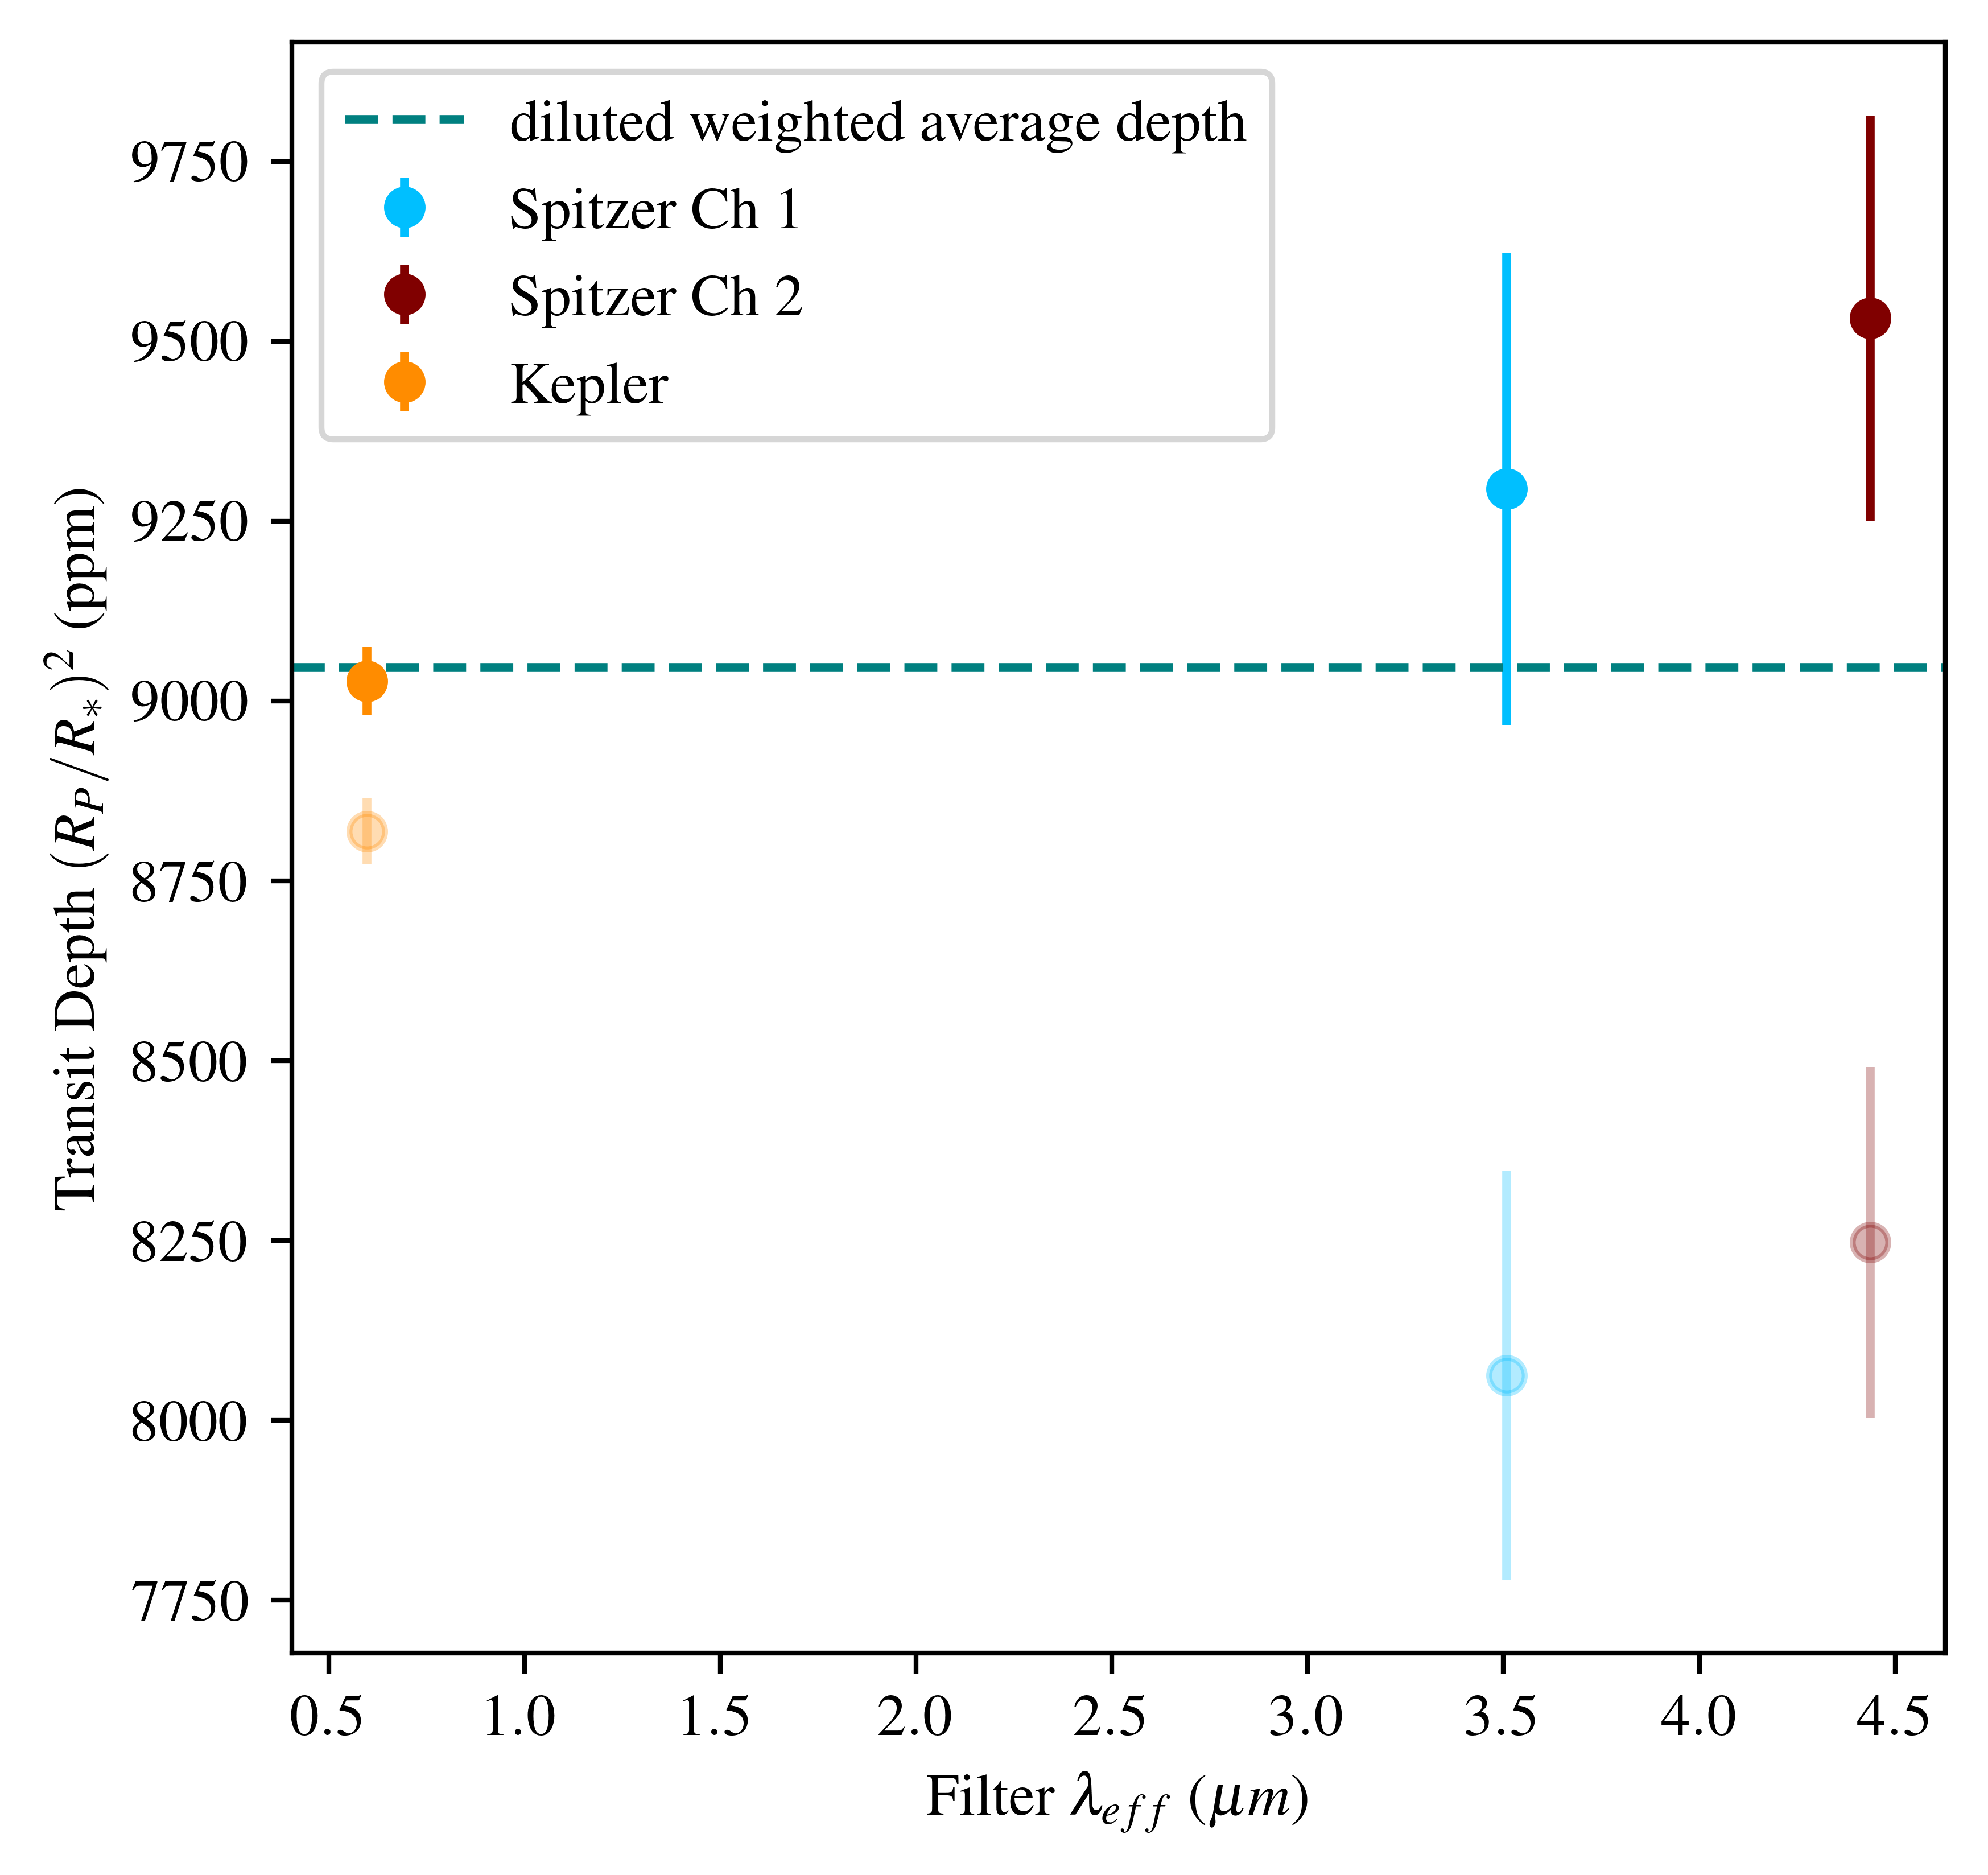

In [256]:
plt.figure(figsize=(5, 5), dpi=750)
lam = 10000 # conversion from angstroms to microns
ch1_lam = 35074.83 / lam
ch2_lam = 44365.56/ lam
kepler_lam = 5978.14/ lam

filter_lams = [ch1_lam, ch2_lam, kepler_lam]

depths_dil = [depth_ch1[0], depth_ch2[0], depth_kepler[0]]
errs_dil = [depth_ch1[1], depth_ch2[1], depth_kepler[1]]

depths_undil = [depth_undil_ch1[0], depth_undil_ch2[0], depth_undil_kepler[0]]
errs_undil = [depth_undil_ch1[1], depth_undil_ch2[1], depth_undil_kepler[1]]


labels = ["Spitzer Ch 1", "Spitzer Ch 2", "Kepler"]
lam_colors = ["deepskyblue", "maroon", "darkorange"]

for i in range (len(depths)):
    
    plt.errorbar(filter_lams[i], depths_dil[i], yerr=errs_dil[i], fmt="^", color=lam_colors[i], alpha=0.3, marker="o")
 #   plt.axhline(depths[i], color=lam_colors[i], linestyle="--", label=labels[i], alpha=0.5)
    
    plt.errorbar(filter_lams[i], depths_undil[i], yerr=errs_undil[i], fmt="^", color=lam_colors[i], label=labels[i], marker="o")
   # plt.axhline(depths[i], color=lam_colors[i], linestyle="--", label=labels[i], alpha=0.5)

plt.axhline(weighted_depth, label="diluted weighted average depth", color="teaL", linestyle="--")

#plt.title("Diluted Transit depth per wavelength of observation ")
plt.xlabel(r"Filter $\lambda_{eff}$ ($\mu m$)")
plt.ylabel("Transit Depth $(R_{P}/R_{*})^2$  (ppm)")
#plt.grid(alpha=0.1)
plt.legend(loc="upper left");

# Calculates $L_{sys, Kepler}$

$L_{sys, Kepler} = SB_{A, Kep} R_{A}^{2} + SB_{B, Kep} R_{B}^{2}$


In [28]:
L_sys_kepler = (SB_A * RA**2 + SB_B * RB**2)

# luminosity of system in ergs/s assuming flux from kepler is zero in optical

In [29]:
# error propagation on L_sys
 # Calculate the partial derivatives with respect to RA and RB
dL_dRA = 2 * RA * SB_A
dL_dRB = 2 * RB * SB_B

    # Calculate the uncertainty (error) in L_sys using error propagation formula
sig_L_sys_kepler = ((dL_dRA * sig_RA) ** 2 + (dL_dRB * sig_RB) ** 2) ** 0.5

In [30]:
print(f"{L_sys_kepler} +/- {sig_L_sys_kepler}")

9.542143659083655e+31 erg / s +/- 7.401145679396661e+30 erg / s


# Calculate $L_{sys, lam}$

Note this is not the true total luminosity of the system as seen by Spitzer, but the luminosity of the stars 

$L_{sys, ch1} = SB_{A, ch1} R_{A}^{2} + SB_{B, ch1} R_{B}^{2}$

$L_{sys, ch2} = SB_{A, ch2} R_{A}^{2} + SB_{B, ch2} R_{B}^{2}$


In [31]:
L_sys_ch1 = (SB_A_ch1 * RA**2 + SB_B_ch1 * RB**2)

# luminosity of system in ergs/s assuming flux from kepler is zero in optical
# error propagation on L_sys
 # Calculate the partial derivatives with respect to RA and RB
dL_dRA = 2 * RA * SB_A_ch1
dL_dRB = 2 * RB * SB_B_ch1

    # Calculate the uncertainty (error) in L_sys using error propagation formula
sig_L_sys_ch1 = ((dL_dRA * sig_RA) ** 2 + (dL_dRB * sig_RB) ** 2) ** 0.5

print(f"{L_sys_ch1} +/- {sig_L_sys_ch1}")

7.58538955327845e+29 erg / s +/- 5.991925646089143e+28 erg / s


In [32]:
L_sys_ch2 = (SB_A_ch2 * RA**2 + SB_B_ch2 * RB**2)

# luminosity of system in ergs/s assuming flux from kepler is zero in optical
# error propagation on L_sys
 # Calculate the partial derivatives with respect to RA and RB
dL_dRA = 2 * RA * SB_A_ch2
dL_dRB = 2 * RB * SB_B_ch2

    # Calculate the uncertainty (error) in L_sys using error propagation formula
sig_L_sys_ch2 = ((dL_dRA * sig_RA) ** 2 + (dL_dRB * sig_RB) ** 2) ** 0.5

print(f"{L_sys_ch2} +/- {sig_L_sys_ch2}")

6.943241034982853e+29 erg / s +/- 5.225513086916075e+28 erg / s


# Fix nightside planet emission by using different Spitzer luminosities

### $F_{N, \lambda} = \left(\frac{\delta_{Kepler}}{\delta_{\lambda}}\right)\left(\frac{L_{sys, Kepler} SB_{A, \lambda}}{SB_{A, Kepler}} - L_{sys, \lambda}\right)$

In [65]:
# help 
Fp_ch1 = np.abs((SB_A_ch1 * Rp**2/depth_ch1[0]) - SB_A_ch1 * RA**2 - SB_B_ch1 * RB**2)/Rp**2

In [48]:
# ch 1
del_ratio_ch1 = depth_kepler[0]/depth_ch1[0]
print(del_ratio_ch1)
term2_ch1 = (L_sys_kepler * SB_A_ch1 / SB_A) - L_sys_ch1
print(L_sys_kepler)
print(SB_A_ch1)
print(SB_A)
FN_ch1 = del_ratio_ch1 * term2_ch1
print(FN_ch1)

1.0951071170050475
9.542143659083655e+31 erg / s
121672861.878721 erg / (cm2 s)
18880651475.642326 erg / (cm2 s)
-1.5727181393423958e+29 erg / s


In [36]:
# ch 2
del_ratio_ch2 = depth_kepler[0]/depth_ch2[0]
term2_ch2 = L_sys_kepler * SB_A_ch2 / SB_A - L_sys_ch2

FN_ch2 = del_ratio_ch2 * term2_ch2

# Calculate nighside planet emission (LN)

Brown dwarf nightside emission (ergs/s) is equal to the total system luminosity as seen by Kepler times a factor of the ratio of kepler transit depth to infrared (Spitzer) transit depth minus one. 

$L_{N, ch} = L_{sys}(\delta_{kepler}/\delta_{ch} - 1)$


### CH 1 

In [ ]:
# nightside emission as seen by spitzer ch1 in ergs/s
LN_ch1 = L_sys * (depth_kepler[0]/depth_ch1[0] - 1)

In [ ]:
print(depth_kepler[0]/depth_ch1[0] - 1)

In [ ]:
# error on LN_ch1:
    
# assigns variables 
Rp, sig_Rp = Rp_kepler  #radius kepler in cm
del_lam, sig_lam = depth_ch1 # depth other channel in ppm
del_k, sig_k = depth_kepler # depth kepler in ppm

# uncertainty on value:
# find error on del_k/del_lam:
sig_delk_dellam = (del_k/del_lam) * np.sqrt((sig_k/del_k)**2 + (sig_lam/del_lam)**2)

# find error on total LN_ch1 calculation
sig_LC_ch1 = LN_ch1 * np.sqrt((sig_delk_dellam/(del_k/del_lam))**2 + (sig_L_sys/L_sys)**2)

In [ ]:
print(f"{LN_ch1} +/- {sig_LC_ch1}")

### CH 2

In [ ]:
# nightside emission as seen by spitzer ch2 in ergs/s
LN_ch2 = L_sys * (depth_kepler[0]/depth_ch2[0] - 1)

In [ ]:
# error on LN_ch2: 
# error on LN_ch1:
    
# assigns variables 
del_lam, sig_lam = depth_ch2 # depth other channel in ppm

# uncertainty on value:
# find error on del_k/del_lam:
sig_delk_dellam = (del_k/del_lam) * np.sqrt((sig_k/del_k)**2 + (sig_lam/del_lam)**2)

# find error on total LN_ch1 calculation
sig_LC_ch2 = LN_ch2 * np.sqrt((sig_delk_dellam/(del_k/del_lam))**2 + (sig_L_sys/L_sys)**2)

In [ ]:
# sanity check: luminosity in ch1 should be higher than in ch2 because the transit depth in ch1 is smaller than in ch2
# meaning more emission is present in ch1 (3.6) than in ch2 (4.5)
print(f"{LN_ch2} +/- {sig_LC_ch2}")

# Calculate surface brightness (SB) in Spitzer channels from nightside emission 
The flux (ergs/cm^2/s) from the brown dwarf in a certain Spitzer channel is equal to the emission of the planet (ergs/s) divided by the radius sqaured of the planet in cm squared. 

derived from: 
$L_{N, ch} = SB_{P, ch} R_{P}^{2}$

$SB_{ch} = L_{N, ch}/R_{P}^{2}$

### CH 1

In [64]:
# Surface brightness of BD in ch 1 in ergs/cm^2/s/st

SB_ch1 = FN_ch1 / (Rp**2 * 4 * np.pi * u.steradian)

-292506037.7562504 erg / (cm2 s sr)


In [39]:
# error propagation 
sig_Rp2 = sig_Rp * 2 * Rp # error on planet radius squared

sig_SB_ch1 = SB_ch1 * np.sqrt((sig_LC_ch1/LN_ch1)**2 + (sig_Rp2/Rp**2)**2) # calculate error on flux from planet

NameError: name 'sig_LC_ch1' is not defined

In [40]:
print(f"{SB_ch1} +/- {sig_SB_ch1}")

NameError: name 'sig_SB_ch1' is not defined

### CH 2

In [ ]:
# Surface brightness of BD in ch 1 in ergs/cm^2/s

SB_ch2 = LN_ch2 / (Rp**2 * 4 * np.pi * u.steradian)

In [ ]:
# error propagation 

sig_SB_ch2 = SB_ch2 * np.sqrt((sig_LC_ch2/LN_ch2)**2 + (sig_Rp2/Rp**2)**2) # calculate error on flux from planet

In [ ]:
print(f"{SB_ch2} +/- {sig_SB_ch2}")

# Finds brightness temperature of BD in Spitzer channels 
Find the temperature of a blackbody with the same emission per wavelength as the BD

Integrate a Planck function $P(\lambda, T)$ with a known temperature $T$ over the wavelength range of the Spitzer filter $\lambda$, scaled by the transmission profile $t(\lambda)$ of the certain Spitzer filter. 

$$ SB_{ch} = \int P(\lambda, T) t(\lambda) \, d\lambda$$

Recall $SB_{ch} = L_{N, ch}/R_{P}^{2}$ which was just calculated. 

We can set the calculated $SB_{ch}$ equal to an integral over the Spitzer filter range and find which temperature $T$ produces a $SB_{ch}$ closest to the $SB_{ch}$ predicted by the Spitzer channel transit depth. 

Units: integrate Planck function $ergs/cm^{2}/s/A/st$ over $A$ to get $SB_{ch}$ in $ergs/cm^{2}/s/st$, then multiply by $4\pi$ to convert to $ergs/cm^{2}/s$

In [ ]:
# generates a blackbody function 
T = 1500 # temperature guess 
unit_scale = 1 * (u.erg / u.cm**2 / u.steradian / u.s / u.AA)
bb = BlackBody(temperature=T*u.K, scale=unit_scale) # generates blackbody function with temp T in units of ergs/s/cm^2/AA/str

### CH 1 

In [ ]:
# scales blackbody function by Spitzer CH 1 transmission profile 

# grabs wavelength, transmission profile from Spitzer ch 1 filter 
lam_ch1 = spitz_ch1_raw[:, 0] * u.AA
trans_ch1 = spitz_ch1_raw[:, 1]

# evalulates blackbody function at same wavelengths as present in Spitzer transmission filter 
bb_ch1 = bb(lam_ch1)

# scales blackbody function by Spitzer transmission profile
integrand_ch1 = bb_ch1 * trans_ch1

# integrates integrand (blackbody * transmission) over wavelength range of filter 
SB_ch1_planck_str = sum(
    [(integrand_ch1[i] + integrand_ch1[i-1]) * (lam_ch1[i] - lam_ch1[i-1]) / 2 for i in range(1, len(lam_ch1))]
)

# scales integrand by 4pi to remove /steradian 
SB_ch1_planck = SB_ch1_planck_str * (4 * np.pi * u.steradian)

In [ ]:
print(SB_ch1_planck)

### CH 2 

In [ ]:
# scales blackbody function by Spitzer CH 1 transmission profile 

# grabs wavelength, transmission profile from Spitzer ch 1 filter 
lam_ch2 = spitz_ch2_raw[:, 0] * u.AA
trans_ch2 = spitz_ch2_raw[:, 1]

# evalulates blackbody function at same wavelengths as present in Spitzer transmission filter 
bb_ch2 = bb(lam_ch2)

# scales blackbody function by Spitzer transmission profile
integrand_ch2 = bb_ch2 * trans_ch2

# integrates integrand (blackbody * transmission) over wavelength range of filter 
SB_ch2_planck_str = sum(
    [(integrand_ch2[i] + integrand_ch2[i-1]) * (lam_ch2[i] - lam_ch2[i-1]) / 2 for i in range(1, len(lam_ch2))]
)

# scales integrand by 4pi to remove /steradian 
SB_ch2_planck = SB_ch2_planck_str * (4 * np.pi * u.steradian)

In [ ]:
print(SB_ch2_planck)

# Runs minimization function to calculate bestfit temperature on BD 

In [67]:
# imports scipy minimization function 
from scipy.optimize import minimize_scalar
from scipy import stats

unit_scale = 1 * u.erg/(u.s * (u.cm)**2 * u.AA * u.steradian) # units for blackbody function 

In [68]:
# defines a log likelihood function for temperature
def minimize_func(T, transmission_profile, SB_ch):
    
    lam_ch = transmission_profile[:, 0] * u.AA
    trans_ch = transmission_profile[:, 1]
    
    # generates a blackbody function 
    bb = BlackBody(temperature=T*u.K, scale=unit_scale) # generates blackbody function with temp T in units of ergs/s/cm^2/AA/st
    integrand_ch = bb(lam_ch) * trans_ch
    SB_ch_planck = sum(
        [(integrand_ch[i] + integrand_ch[i-1]) * (lam_ch[i] - lam_ch[i-1]) / 2 for i in range(1, len(lam_ch))]
    ) #* (4 * np.pi * u.steradian) 
    return abs(SB_ch_planck - SB_ch)

In [76]:
temp_ch1 = minimize_scalar(minimize_func, bounds=(100, 1000000), method = "bounded", args=(kep_transmission_raw, SB_ch1))

In [78]:
temp_ch2 = minimize_scalar(minimize_func, bounds=(100, 10000000), method = "bounded", args=(kep_transmission_raw, SB_ch2))

NameError: name 'SB_ch2' is not defined

In [77]:
print("ch1 temp:", temp_ch1.x * u.K)

print("ch2 temp:", temp_ch2.x * u.K)

ch1 temp: 366.99561173440947 K


NameError: name 'temp_ch2' is not defined

# rest is scrap work 
---------------------------

## Functions

In [ ]:
# FUNCTION FOR CALCULATING FLUX OVER A WAVELENGTH
def trapz(lam, flux):
    """
    :param lam: units of AA -> converts to cm
    :param flux array: units of ergs/cm3/s
    :return: surface brightness in ergs/cm2/s
    """

    integral = sum(
        [(flux[i] + flux[i-1]) * (lam[i] - lam[i-1]) / 2 for i in range(1, len(lam))]
    )

    return integral  # ergs/cm^2/s


def find_lum_per_filter(trans_filter, spectrum):
    """
    :param filter: array of filter transmission profile information in the form ((wavelength (A)), (transmission))
    :param spectrum: Stellar spectrum model array in the form ((wavelength(A)), (flux (erg/cm2/s/A)))
    :return: integrated flux per wavelength of filter in ergs/cm^2/s
    """
    
    # indices in star wavelength array where wavelength is equal to the smallest / largest wavelength in the star spectrum array
    i_min = (np.abs(spectrum[:, 0] - np.min(trans_filter[:, 0]))).argmin()
    i_max = (np.abs(spectrum[:, 0] - np.max(trans_filter[:, 0]))).argmin()

    # shortens star spectrum arrays at desired indices
    spec = spectrum[i_min:i_max]

    # Creates interpolation function to transpose x axis from star data onto spitzer transmission spectrum
    interp_func = interp1d(trans_filter[:, 0], trans_filter[:, 1])

    # calculates new x axis, uses interpolation function to find new y axis
    wavelength = spec[:, 0] * u.AA # wavelength from star array, adds correct units
    flux = spec[:, 1] * (u.erg / u.cm**2 / u.s / u.AA) # grabs flux from array, adds correct units
    transmission = interp_func(wavelength) # calculates new kepler transmission array values of same length of transmission x values
    scaled_flux = transmission * flux
    
    
    wavelength = wavelength.to(u.cm)
    scaled_flux = scaled_flux.to(u.erg / u.cm**3 /u.s)

    S_star = trapz(wavelength, scaled_flux) # surface brightness of object
    return S_star

## Calculations
### System flux

In [ ]:
# SA, SB in units of ergs/cm^2 /s # surface brightness 
SA = find_lum_per_filter(kep_transmission_raw, spec_A_raw)
SB = find_lum_per_filter(kep_transmission_raw, spec_B_raw)

In [ ]:
print(SA)
print(SB)

In [ ]:
 # Calculate the system luminance (L_sys)
L_sys = RA**2 * SA + RB**2 * SB # + RP**2 * SP

    # Calculate the partial derivatives with respect to RA and RB
dL_dRA = 2 * RA * SA
dL_dRB = 2 * RB * SB

    # Calculate the uncertainty (error) in L_sys using error propagation formula
sig_L_sys = ((dL_dRA * sig_RA) ** 2 + (dL_dRB * sig_RB) ** 2) ** 0.5

In [ ]:
print(L_sys) # vs Lsun = e33 

## Convert depths to surface flux of planets

In [ ]:
def find_Sp(Rp_kepler, depth_lam, depth_k):
    
    # assigns variables 
    Rp, sig_Rp = Rp_kepler  #radius kepler in cm
    del_lam, sig_lam = depth_lam # depth other channel in ppm
    del_k, sig_k = depth_k # depth kepler in ppm

    # plugging values into formula
    Fn = L_sys * (del_k/del_lam - 1) # solve for nighttime flux

    # uncertainty on value:
    # first, find error on del_k/del_lam:
    sig_delk_dellam = (del_k/del_lam) * np.sqrt((sig_k/del_k)**2 + (sig_lam/del_lam)**2)
    sig_Fn = (L_sys * (del_k/del_lam - 1)) * np.sqrt((sig_delk_dellam/(del_k/del_lam))**2 + (sig_L_sys/L_sys)**2)

    # Fn = Rp**2 * Fp(lam)
    # Fp(lam) = Fn / (Rp**2)
    Sp = Fn / (Rp**2) # calculate planet luminosity

    sig_Rp2 = sig_Rp * 2 * Rp # error on planet radius squared

    sig_Sp = Sp * np.sqrt((sig_Fn/Fn)**2 + (sig_Rp2/Rp**2)**2) # calculate error on flux from planet

    return Sp, sig_Sp

In [ ]:
Sp_ch1, _ = find_Sp(Rp_kepler, depth_ch1, depth_kepler)
Sp_ch2, _ = find_Sp(Rp_kepler, depth_ch2, depth_kepler)

In [ ]:
Sp_ch1

In [ ]:
Sp_ch2

# plots planck function, point for Sp to see how overlaps? hmmm

In [ ]:
def Planck(lam, T):
    # takes lam in angstroms - does it???
    h = 6.62617e-27 * u.erg * u.s
    c = 2.99792458e10 * u.cm/u.s
    k_b = 1.3807e-16 * u.cm**2 * u.g / u.s**2 / u.K

    t1 = (2 * h * c**2) /(lam**5) 
    te = (math.e)**((h*c)/(k_b*T*lam))
    eq = t1 * (1/(te - 1)) # full planck function 

    return eq * np.pi # scales by pi??

In [ ]:
lam = kep_transmission_raw[:, 0] * u.AA
T = 1500* u.K
bb = Planck(lam, T)

In [ ]:
plt.plot(lam.value, bb.value)
#plt.loglog();

# this makes me think I am integrating wrong? that my flux should be so much larger than it actially is 


## convert surface brightness to brightness temperature using minimization function (maybe also write that)

In [ ]:
def find_bb_temp(Sp, transmission_filter):
    temp_guess_min = int(input("temp_min:"))
    temp_guess_max = int(input("temp_max:"))
    temp_step = int(input("temp_step:"))
    temp_guesses = np.arange(temp_guess_min, temp_guess_max, 10)

    values = [] # initialzies list for flux per temperature calculations
    lam = transmission_filter[:, 0] * u.AA # converts wavelength array from filter transmission to angstroms
    transmission = transmission_filter[:, 1] # assigns transmission array

    for T in temp_guesses: # iterates over all temperature guesses
        lam = lam.to(u.cm) # converts angstroms to cm 
        flux = Planck(lam, T*u.K) # calculates array of planck function values over wavelength range of filter
        integrand = flux * transmission # scales blackbody flux by transmission of filter
        #integrand = integrand.to(u.erg / u.cm**3 /u.s)
        
        term = trapz(lam, integrand) # integrates scaled flux over wavelength range
        values.append(term) # adds values wit stripped units to array
        
        print(Sp)  
        print(term)
    temp_index = np.abs(values - Sp.value).argmin()
    temp = temp_guesses[temp_index]

    print("Bestfit Temperature:", temp * u.K)
    return temp*u.K

In [ ]:
temp_ch1 = find_bb_temp(SA, spitz_ch1_raw)

In [ ]:
temp_ch2 = find_bb_temp(Sp_ch2, spitz_ch2_raw)